# Recitation 1: some sampling methods

* Accept-reject sampling
* Simple Monte-Carlo integration
* The Box-Muller method for sampling normal RVs

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy
import scipy.stats

# now we can just do unif() to get a U(0,1) RV
unif = np.random.uniform

# Accept-reject sampling

Accept-reject sampling method to generate from $f(x)$:

1. Generate R.V. $Y$ with distribution $g(y)$
2. Generate a $U \sim U(0,1)$
3. If $U<f(Y)/cg(Y)$, output $Y$, otherwise go back to 1

Pre-requisities:

1. $f(y)/g(y)\leq c$ for all $y$
2. If $f(y)>0$, then $g(y)>0$ for all $y$ (otherwise there's no way to sample that $y$)

## Example

Suppose you wanted to sample from the distribution

$$f(x)=\frac{6}{7}\left(x-\frac{1}{2}\right)^2, x\in[0,2]$$

Let's use the following RV for our accept-reject sampling:

$$g(y)=\frac{1}{6}(1+2x), x\in[0,2]$$

In [2]:
def f(x):
    return 6/7*(x-1/2)**2

def g(y):
    return (1+2*y)/6

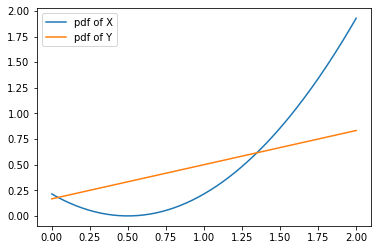

In [3]:
l = np.linspace(0, 2, 200)
plt.plot(l, f(l))
plt.plot(l, g(l))
plt.legend(["pdf of X", "pdf of Y"]);

### Sampling Y

We'll just do inverse transform sampling.

The CDF is given by $1/6(x+1)x$, and so its inverse is $1/2 (\sqrt{24 x + 1}-1)$.

In [4]:
def g_cdf_inv(x):
    return 0.5*(np.sqrt(24*x+1)-1)

In [5]:
def sample_y():
    return g_cdf_inv(unif())

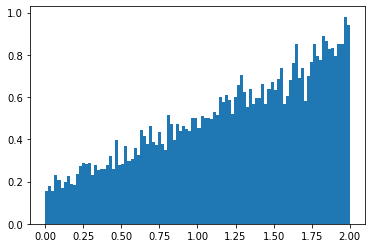

In [6]:
# double check we got it right
plt.hist([sample_y() for _ in range(10000)], bins=100, density=True);

In [7]:
c = np.max(f(l)/g(l))

In [8]:
samples = 10000

samples_left = samples
values = []

tries = 0

while samples_left > 0:
    Y = sample_y()
    if unif() < f(Y) / (c * g(Y)):
        values.append(Y)
        samples_left -= 1
    tries += 1

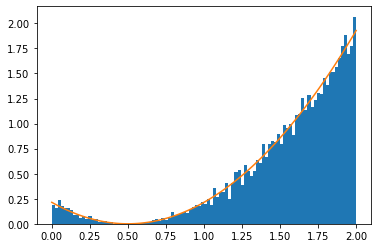

In [9]:
l = np.linspace(0, max(values), 100)
plt.hist(values, bins=100, density=True)
plt.plot(l, f(l))

### Number of tries per sample vs c

In [10]:
tries / samples

2.3157

In [11]:
c

2.314285714285714

# Monte-Carlo integration

Suppose you want to compute

$$V=\int_0^{1/2}e^{x^2}\,dx$$

(As we know, you can't integrate this function analytically.)

We want to change this so the limits are from $0$ to $1$, so do a change of measure:

Do the substitution $x\to z/2$, so $dx=1/2\,dz$, and

$$V=\int_0^1e^{(z/2)^2}\frac{1}{2}\,dz$$

In [12]:
def ex(x):
    return 1/2*np.exp((x/2)**2)

In [13]:
np.mean([ex(unif()) for _ in range(10000)])

0.5454986111431114

In [14]:
# true integral
c = 0.54498710418362222

# Sampling normal RVs: Box-Muller method

The normal distribution is ubiquitous in applications and modelling, and so a lot of people need a lot of random variates from the distribution, so by necessity, a lot of people have spent a lot of time thinking about fast ways to generate them for simulation and other applications.

The Box-Muller method is a fun* way to generate standard normal random variables.

(* Assuming you have a warped sense of fun)

/tmp/ipykernel_1741519/3702142982.py:6: MatplotlibDeprecationWarning: Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().
  ax = fig.gca(projection="3d")


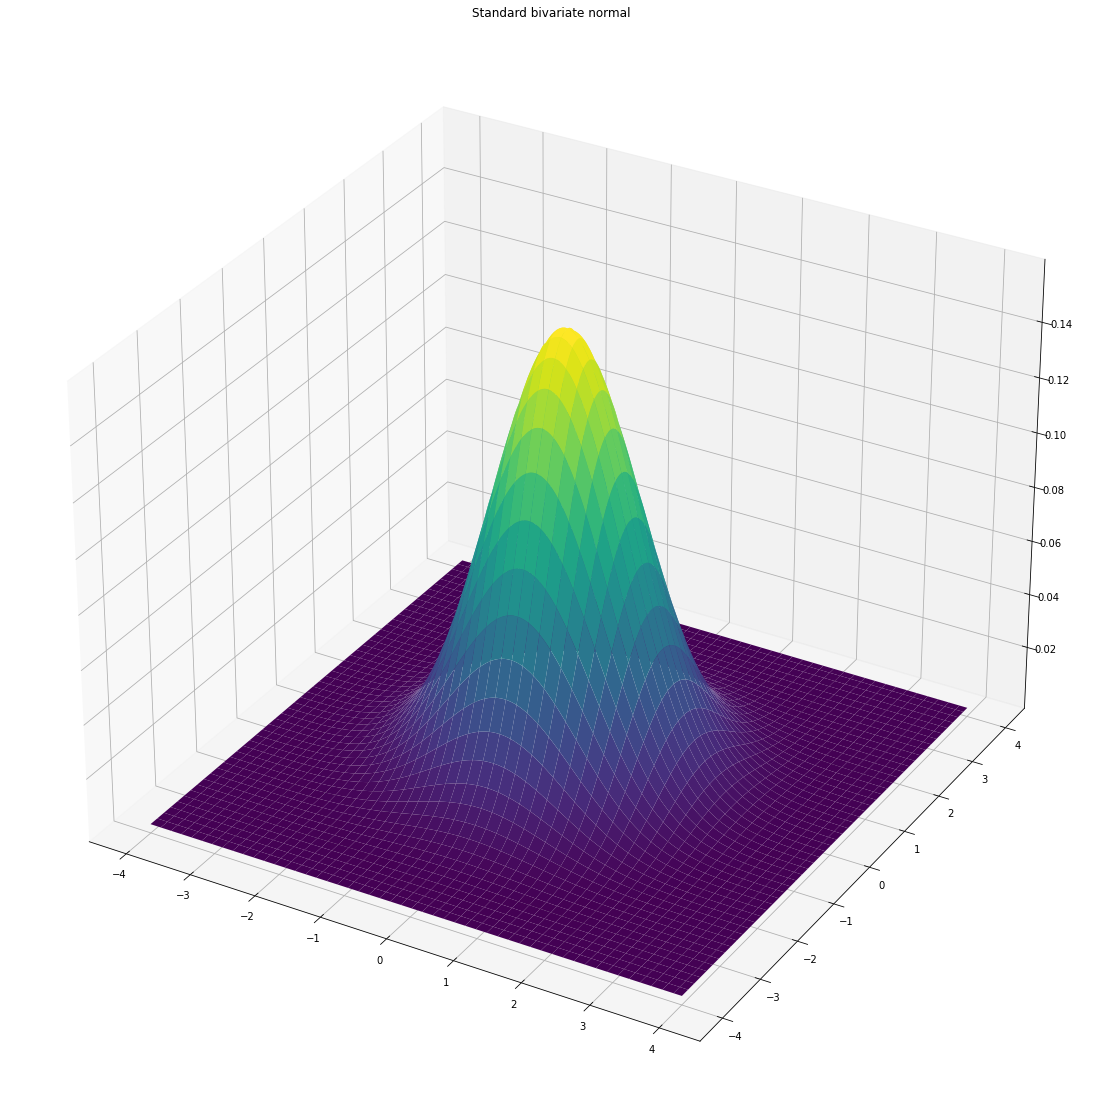

In [15]:
X, Y = np.meshgrid(np.linspace(-4, 4, 200), np.linspace(-4, 4, 200))
pos = np.empty(X.shape + (2,))
pos[:, :, 0], pos[:, :, 1] = X, Y
rv = scipy.stats.multivariate_normal([0, 0], [[1, 0], [0, 1]])
fig = plt.figure(figsize=(20, 20))
ax = fig.gca(projection="3d")
ax.plot_surface(X, Y, rv.pdf(pos), cmap="viridis", linewidth=0)
plt.title("Standard bivariate normal");

## Two facts

Suppose you have a pair of independent standard normal RVs $X$ and $Y$.

Firstly, we know that their joint distribution, $(X,Y)$ is a multivariate (bivariate) standard normal in two dimensions, and we know it's got radial symmetry. So if you randomly sample a point from that joint distribution, its angle should be "random", i.e. uniformly distributed around $[0,2\pi]$.

Second fact: if you compute $Z=X^2+Y^2$, then this is distributed according to an $\mbox{Exp}(1/2)$ distribution (exponential with rate $\lambda=1/2$).

Note also that $Z$ is the square of $\sqrt{X^2+Y^2}$, i.e. it's the length of a randomly sampled point in the joint distribution of $(X,Y)$.

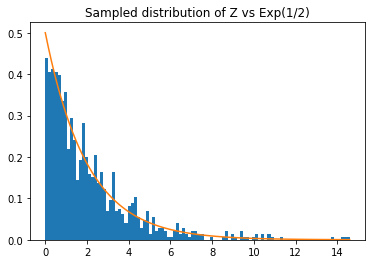

In [16]:
# make some standard normals
samples = 1000
Xs = scipy.random.normal(size=samples)
Ys = scipy.random.normal(size=samples)

# compute Z = X^2+Y^2
# the zip() glues the two lists together in the same way a zipper joins two bits of fabric together
Z = [X**2 + Y**2 for (X, Y) in zip(Xs, Ys)]

# construct the pdf of an exponential(1/2) R.V.
exp_x_axis = np.linspace(0, max(Z), 100)
exp_half_pdf = 0.5 * np.exp(-0.5*exp_x_axis)

# plot it all
plt.hist(Z, bins=100, density=True)
plt.plot(exp_x_axis, exp_half_pdf)
plt.title("Sampled distribution of Z vs Exp(1/2)");

## Idea

Generate the joint point $(X,Y)$ instead by first picking a random angle and then a radius using an exponential with rate $1/2$.

In [17]:
samples = 10000
angles = np.random.uniform(high=2*np.pi, size=samples)
# note that this takes in the scale, which is 1/lambda
radii_squared = np.random.exponential(scale=1/0.5, size=samples)

radii = np.sqrt(radii_squared)
X = radii * np.cos(angles)
Y = radii * np.sin(angles)

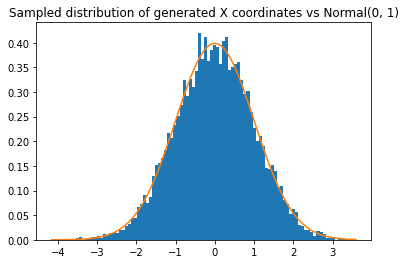

In [18]:
# construct the pdf of a std normal for comparison
normal_x_axis = np.linspace(min(X), max(X), 100)
normal_half_pdf = 1 / np.sqrt(2*np.pi) * np.exp(-0.5*normal_x_axis**2)

plt.hist(X, bins=100, density=True);
plt.plot(normal_x_axis, normal_half_pdf)
plt.title("Sampled distribution of generated X coordinates vs Normal(0, 1)");